In [8]:
from pathlib import Path
import numpy as np
import pandas as pd

import dask
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
from caseva.models import ThresholdExcessModel

In [9]:
# Define input data location.
PATH_ROOT = Path().resolve().parent
PATH_DATA = PATH_ROOT / "data"

In [10]:
@dask.delayed
def calc_single_sample(extremes, threshold, num_years, m):
    sample = np.random.choice(extremes, size=extremes.size, replace=True)

    model = ThresholdExcessModel()
    model.fit(data=sample, threshold=threshold, num_years=num_years)

    probas = np.arange(1, m + 1) / (m + 1)
    quants = model.dist.quantile(model.theta, probas)

    distance = np.quantile(sample, probas) - quants

    return np.sum(np.abs(distance)) / m


def calc_bootstrap_mean_dist(extremes, threshold, num_years, k, m):

    calculations = []

    for _ in range(k):
        calc = calc_single_sample(extremes, threshold, num_years, m)
        calculations.append(calc)
    
    return dask.delayed(np.mean)(calculations)


def get_threshold(data, num_years, k, m, min_num_extremes=10):


    thresholds = np.quantile(data, np.linspace(0.8, 0.995, 100))
    thresholds = np.linspace(20, 35, 50)
    mean_distances = np.zeros_like(thresholds)
    
    for i, u in enumerate(thresholds):

        extremes = data[data > u]
        if extremes.size < min_num_extremes:
            mean_distances[i] = np.inf
            continue

        try:
            mean_distances[i] = calc_bootstrap_mean_dist(extremes, u, num_years, k, m).compute()
        except:
            mean_distances[i] = np.inf

    
    min_indx = np.argmin(mean_distances)
    return mean_distances[min_indx], mean_distances
        


In [11]:
# Load data / define threshold
data = pd.read_csv(PATH_DATA / "rain.csv", parse_dates=[0])
years = {date.year for date in data["Date"]}
num_years = max(years) - min(years) + 1


In [12]:
with LocalCluster(n_workers=10, threads_per_worker=1) as cluster:
    with Client(cluster) as client:
        threshold, dists = get_threshold(data["Rainfall"].values, num_years, k=250, m=500)

2024-12-22 23:35:10,200 - distributed.worker - WARNING - Compute Failed
Key:       calc_single_sample-9c00a436-13ac-44ec-950b-0b3af4daa979
Function:  calc_single_sample
args:      (array([31.8, 32.5, 27.9, 31.8, 44.5, 28.7, 30.5, 43.2, 25.9, 26.2, 35.6,
       38.1, 27.7, 32. , 31.8, 27.4, 33. , 26.4, 39.1, 30.5, 31.8, 32.3,
       26.9, 33. , 28.4, 30.5, 32.5, 30. , 48.5, 35.3, 40.6, 26.4, 27.2,
       29.2, 30.5, 26.7, 34.3, 29.2, 29.2, 32.8, 27.4, 27.9, 30.5, 45.7,
       31.8, 33.5, 33.5, 31.8, 34.8, 35.3, 37.8, 25.9, 28.4, 76.7, 25.9,
       32.3, 26.9, 27.2, 34. , 27.9, 25.9, 33.8, 28.2, 36.6, 28.7, 30.5,
       45.7, 86.6, 29.5, 35.6, 47.8, 47.5, 28.2, 34.3, 26.7, 27.7, 30. ,
       48.5, 26.7, 26.9, 28.4, 30.7, 43.4, 59.4, 29. , 35.1, 53.3, 25.9,
       33.5, 30.5, 30.2, 29. , 40.9, 42.7, 30. , 83.3, 54.9, 59.2, 26.9,
       28.7, 31.8, 26.7, 29.5, 27.4, 28.4, 30. , 37.3, 28.2, 32.5, 34. ,
       67.3, 31.2, 30.2, 25.9, 36.1, 36.8, 29.5, 38.4, 27.7, 27.9, 26.9,
       31. , 29.

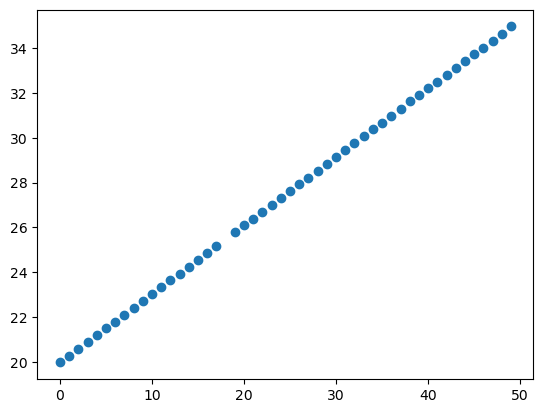

In [13]:
plt.scatter(np.arange(dists.size), dists)

In [14]:
dists

array([19.98469254, 20.28702727, 20.59378009, 20.90120154, 21.20337093,
       21.51018719, 21.80911747, 22.1151803 , 22.42606537, 22.73194283,
       23.03118025, 23.33813618, 23.64266315, 23.94857918, 24.24944319,
       24.56113626, 24.86572044, 25.17312045,         inf, 25.78696927,
       26.0917307 , 26.39256035, 26.70040499, 26.99944527, 27.31402552,
       27.61855547, 27.92023536, 28.22584963, 28.53555818, 28.84413291,
       29.16062733, 29.44922854, 29.74210028, 30.05883626, 30.37266305,
       30.65286617, 30.9679362 , 31.27823994, 31.61648721, 31.8839559 ,
       32.19549538, 32.47096588, 32.81016198, 33.09961539, 33.43249723,
       33.72777689, 33.98871773, 34.30278785, 34.62044633, 34.95569188])

In [15]:
threshold

19.98469253931017

In [ ]:
u = 2.5
excesses = data["Rainfall"][data["Rainfall"] > u].values - u

k = 50
m = 50



        res=calc_bootstrap_mean_dist(excesses, u, num_years, k, m).compute()

In [ ]:
res

In [ ]:
thresholds = np.quantile(data["Rainfall"], np.linspace(0.5, 0.98, 50))

k = 100
m = 500
mean_distances = np.zeros_like(thresholds)
num_excesses = np.zeros_like(thresholds, dtype=int)


for i, u in enumerate(thresholds):

    extremes = data["Rainfall"][data["Rainfall"] > u].values
    excess = extremes - u
    num_excesses[i] = len(excess)

    if num_excesses[i] < 10:
        continue

    mean_distances[i] = calc_bootstrap_mean_dist(excess, k, m).compute()

    except:


In [ ]:
thresh = np.quantile(data["Rainfall"], np.linspace(0.5, 0.98, 50))
mean_distances = np.zeros_like(thresh)
#xis = np.zeros_like(thresh)
#sigmas = np.zeros_like(thresh)
num_excesses = np.zeros_like(thresh, dtype=int)
seed = 0
rng = np.random.default_rng(seed)

k = 100
m = 500

for i, u in enumerate(thresh):

    extremes = data["Rainfall"][data["Rainfall"] > u].values
    excess = extremes - u
    num_excesses[i] = len(excess)

    if num_excesses[i] < 10:
        continue

    # mle_0 = excess.mean()

    # model = ThresholdExcessModel(
    #     data=extremes, threshold=u, num_years=num_years
    # )
    # model.fit()

    #xis[i] = model.theta[0]
    #sigmas[i] = model.theta[1]

    distances = np.zeros(k)

    try:
        for j in range(k):

            x = rng.choice(excess, size=num_excesses[i], replace=True)
            mle = x.mean()

            model = ThresholdExcessModel(
                data=x, threshold=u, num_years=num_years
            )
            model.fit()
            quants = model.eval_quantile(np.arange(1, m+1) / (m + 1))

            distances[j] = np.sum(np.abs(np.quantile(x, np.arange(1, m+1) / (m + 1)) - quants)) / m
        mean_distances[i] = distances.mean()
    except:
        mean_distances[i] = np.nan


In [ ]:
min_indx = np.argmin(mean_distances[~np.isnan(mean_distances)])
chosen_threshold = thresh[min_indx]
chosen_threshold